# AI4Food - A Challenge for Crop Type Classification at Field Level

## Get started with the challenge

This notebook will get you started with downloading, exploring and analysing the input and output data of the challenge.

The proposed challenge will focus on crop type classification based on a time-series input of _Sentinel-1_, _Sentinel-2_ and _Planet Fusion_ data. The challenge will cover two areas of interest, in Germany and South Africa, with high-quality cadastral data on field boundaries and crop types as ground truth input. 

The challenge will consist of two tracks:
  * Within-season crop identification, over the South Africa AOI
  * Reusability of models for crop identification from one growing season to the next, over the Germany AOI

The participants will not be required to participate in both challenges. However, the evaluation mechanism behind both tracks are the same, as well as the rules and prize catalogue.

This notebook showcases how to download and process the data, but you are free to use any open souce Python library specifically designed to deal with Earth Observation data such as [eo-learn](https://eo-learn.readthedocs.io/en/latest/index.html). In this notebook, the data is stored into `EOPatches` as `numpy` arrays and `geopandas` dataframes to facilitate processing operations and `torch` is preferred for training. However, you can use any other Python tool of preference to process the provided data.

The notebook also showcases how to generate a valid submission file.

As per challenge rules, the following applies:
 * no data source other than the ones provided can be used to produce your outputs;
 * pre-trained models are not allowed;
 * the test data cannot be used for training of the models; 
 * the target _cultivated land_ map cannot be used as an input to the method (i.e. trivial solution).

Code for the winning solutions will be reviewed to ensure rules have been followed.

The content of the notebook is as follows:

0. [Requirements](#requirements)


1. [Data overview](#data-overview)

   1.1. [Area of Interest for Brandenburg](#aoi1)
   
   1.2. [Data Types for Brandenburg](#dt1)
   
   1.3. [Area of Interest for South Africa](#aoi2)

   1.4. [Data Types for South Africa](#dt2)
   
   1.5. [Data download](#data-download)
   
   
2. [Data processing](#data-processing)


3. [Submission example](#submission-example)

   3.1 [Prepare a submission](#prepare-a-submission)

In [ ]:
# ensure you have the required python packages
import sys
!{sys.executable} -m pip install -r requirements.txt


In [3]:
# Jupyter notebook related
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [23]:
# Built-in modules
import os
import glob
import json
from typing import Tuple, List
from datetime import datetime, timedelta
import pickle
import shutil
import warnings
warnings.filterwarnings('ignore')

# Basics of Python data handling and visualization
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm

# Data reding for training validation purposes:
from utils.data_transform import PlanetTransform
from utils.planet_reader import PlanetReader
from utils.sentinel_1_reader import S1Reader
from utils.sentinel_2_reader import S2Reader
from utils.data_loader import DataLoader
from utils.baseline_models import SpatiotemporalModel
from utils import train_valid_eval_utils as tveu
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn import NLLLoss
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix


## 0. Requirements  <a name="requirements"></a>

In order to download the data through the provided APIs you would need to set-up an account for [Radiant Earth Foundation](https://www.radiant.earth/). Check the following options.

#### If you are using the Radiant Earth Foundation resources

TODO

#### If you are using your own resources

TODO
 
#### If you cannot use the APIs

Check the challenge description for alternative options to retrieve the data as a single zipped file.

## 1. Data Overview <a name="data-overview"></a>

This section gives an overview of all the necessary data to train your model and how to download them. 

In general, the data sources to download are the following:

 * the reference polygons including target fields and crop types to define the area-of-interest (AOI);
 * the Sentinel-1 and Sentinel-2 time-series;
 * the Planet Fusion time-series;
 * the reference polygons defining the cultivated land labels. 
 
The AOIs chosen for this challenge are in the [Brandenburg State of Germany](https://en.wikipedia.org/wiki/Brandenburg) and the [Republic of South Africa](https://en.wikipedia.org/wiki/South_Africa) as detailed below. 

**Brandenburg-Germany Data** 

The Brandenburg-Germany data contains following time series in UTM zone 33N (i.e. `epsg:32633`) from _Sentinel-1_, _Sentinel-2_ and _Planet Fusion_:
 * **For Training:** 
    * _Planet Fusion_ Surface Reflection (PF-SR) data of 2018 from tile 18E-242N consisting of 365 daily observations, approximately 122 GB,
    * _Sentinel-1_ ascending and descending orbit observations of entire 2018 from tile 18E-242N, approximately 9 GB,
    * _Sentinel-2_ observations of entire 2018 from tile 18E-242N, approximately 12 GB,
    * _Ground-truth:_ _brandenburg_crops_train_2018.geojson:_ crop fields with `crop_ids` and `crop_names` based on cadastral data.
 * **For Testing:** 
    * _Planet Fusion_ Surface Reflection (PF-SR) data of 2019 from tile 17E-243N consisting of 365 daily observations, approximately 122 GB,
    * _Sentinel-1_ ascending and descending orbit observations of entire 2019 from tile 17E-243N, approximately 9 GB,
    * _Sentinel-2_ observations of entire 2019 from tile 17E-243N, approximately 12 GB,
    * _No Ground-truth_ will be released for testing, it is reserved for the evaluation of challenge submissions. 
     
**South Africa Data** 

The South-Africa data contains following time series in UTM zone 34S (i.e. `epsg:32633`) from _Sentinel-1_, _Sentinel-2_ and _Planet Fusion_:
 * **For Training:** 
    * _Planet Fusion_ Surface Reflection (PF-SR) data from tiles 19E-258N and 19E-259N consisting of 244 daily observations between April 2017 - December 2017, approximately 155 GB,
    * _Sentinel-1_ ascending orbit observations of 2017 from tiles 19E-258N and 19E-259N, approximately 3.6 GB,
    * _Sentinel-2_ observations of 2017 from tiles 19E-258N and 19E-259N, approximately 13 GB,
    * _Ground-truth:_ _19E-258N-crop-labels-8bit_2017.geojson_ and _19E-259N-crop-labels-8bit_2017.geojson_,  based on cadastral data.
     
 * **For Testing:** 
    * _Planet Fusion_ Surface Reflection (PF-SR) data from tile 20E-259N consisting of 244 daily observations between April 2017 - December 2017, approximately 77 GB,
    * _Sentinel-1_ ascending orbit observations of 2017 from tile 20E-259N, approximately 1.8 GB,
    * _Sentinel-2_ observations of 2017 from tile 20E-259N, approximately 4.6 GB,
    * _No Ground-truth_ will be released for testing, it is reserved for the evaluation of challenge submissions. 
 



In [ ]:
# TODO: CHANGE THIS AFTER HAVING DOWNLOAD LINK!!!


brandenburg_sentinel_2_dir='/mnt/ushelf/datasets/ai4food_challenge/planet/UTM-24000/33N'

southafrica_gt_1_dir='/mnt/ushelf/datasets/ai4food_challenge/brandenburg-gt/19E-258N-crop-labels-8bit.tif.geojson'
southafrica_gt_2_dir='/mnt/ushelf/datasets/ai4food_challenge/brandenburg-gt/19E-259N-crop-labels-8bit.tif.geojson'


In [5]:
#CHECK TRAINING DATA



### 1.1 Area of Interest for Brandenburg <a name="aoi1"></a>

In order to check the AOI for Brandenburg, you can start with the ground-truth file: _brandenburg_crops_train_2018.geojson_. After your download, it is supposed to be placed in `data` folder of this notebook:

In [10]:
brandenburg_gt_dir='data/brandenburg-gt/brandenburg_crops_train_2018.geojson'

In order to explore data types in the ground truth, you can run the following cell. It will summarize the `geojson` data belonging to the AOI, which have 2534 entries, and 5 columns representing field ID, area of the field in square meters, length of the field in meters, crop ID, crop name and the geomtry of the field as polygon:  

In [11]:
#CHECK TARGET (LABEL) DATA FORMAT:
brandenburg_gt=gpd.read_file(brandenburg_gt_dir)
print('INFO: Number of fields: {}\n'.format(len(brandenburg_gt)))
brandenburg_gt.info()
brandenburg_gt.head()


INFO: Number of fields: 2534

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fid         2534 non-null   int64   
 1   SHAPE_AREA  2534 non-null   float64 
 2   SHAPE_LEN   2534 non-null   float64 
 3   crop_id     2534 non-null   int64   
 4   crop_name   2534 non-null   object  
 5   geometry    2534 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 118.9+ KB


,fid,SHAPE_AREA,SHAPE_LEN,crop_id,crop_name,geometry
0,54,4400.70910,293.870062,9,Forage Crops,"MULTIPOLYGON (((449042.600 5827711.200, 449082..."
1,3935,299598.99930,2574.818018,1,Wheat,"MULTIPOLYGON (((455395.090 5828098.210, 455395..."
2,4073,194110.48135,1913.745250,1,Wheat,"MULTIPOLYGON (((452593.690 5827525.940, 452580..."
3,4724,15059.00790,1181.569204,8,Meadows,"MULTIPOLYGON (((433352.160 5819538.890, 433376..."
4,5336,75017.01935,1506.996389,2,Rye,"MULTIPOLYGON (((454516.350 5826887.890, 454531..."


When you look at the crop labels and crop names you are supposed to see 9 crop types with the following IDs:
 * 1: Wheat
 * 2: Rye
 * 3: Barley
 * 4: Oats
 * 5: Corn
 * 6: Oil Seeds
 * 7: Root Crops
 * 8: Meadows
 * 9: Forage Crops

In [12]:
#CHECK LABEL IDs AND LABEL NAMES: 

label_ids=brandenburg_gt['crop_id'].unique()
label_names=brandenburg_gt['crop_name'].unique()

print('INFO: Label IDs: {}'.format(label_ids))
print('INFO: Label Names: {}'.format(label_names))


INFO: Label IDs: [9 1 8 2 3 5 6 7 4]
INFO: Label Names: ['Forage Crops' 'Wheat' 'Meadows' 'Rye' 'Barley' 'Corn' 'Oil Seeds'
 'Root Crops' 'Oats']


These plant types are not evenly planted in the agricultural fields, so you can observe the distribution of fields with each particular crop as below: 

INFO: Number of Fields by Crop Type: 
Meadows         954
Forage Crops    339
Wheat           305
Rye             279
Corn            251
Oil Seeds       201
Barley          137
Oats             45
Root Crops       23
Name: crop_name, dtype: int64


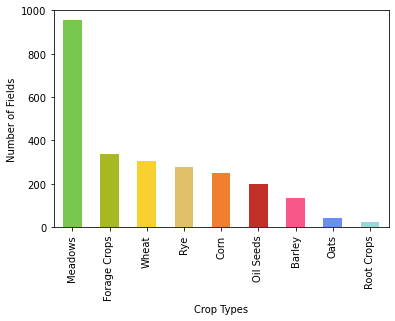

In [11]:
#CHECK FIELD DISTRIBUTION BY LABEL: 

value_counts=brandenburg_gt['crop_name'].value_counts()

colors_list = ['#78C850','#A8B820','#F8D030','#E0C068', '#F08030', '#C03028', '#F85888','#6890F0','#98D8D8'] 
ax=value_counts.plot.bar(color=colors_list)
ax.set_ylabel("Number of Fields")
ax.set_xlabel("Crop Types")

print('INFO: Number of Fields by Crop Type: \n{}'.format(value_counts))


However, if we look at the per hectare distribution of each crop, we will see a different distribution, because some crops seem usually planted in larger areas:

INFO: Total Hectare per Crop Type: 
            crop_name  total_hectare
crop_id                             
1.0             Wheat    6633.129427
2.0               Rye    4601.042741
3.0            Barley    2966.949219
4.0              Oats     458.835674
5.0              Corn    5606.791864
6.0         Oil Seeds    5271.580641
7.0        Root Crops     165.655733
8.0           Meadows    2373.457948
9.0      Forage Crops    2191.064253


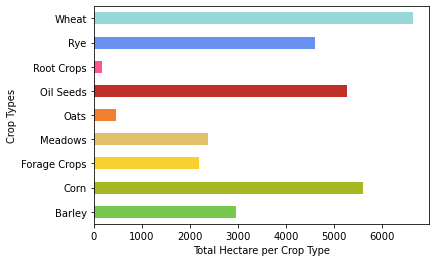

In [12]:
#CHECK TOTAL HECTARE DISTRIBUTION BY LABEL: 

hectare_distribution = pd.DataFrame(columns=["crop_name", "total_hectare"])
for name, group in brandenburg_gt.groupby('crop_name'):
    total_hectare=group['SHAPE_AREA'].sum()/10000 # convert to m2 to hectare
    hectare_distribution=hectare_distribution.append({'crop_id':group.iloc[0]['crop_id'], 'crop_name':name, 'total_hectare':total_hectare}, ignore_index=True)

hectare_distribution.set_index('crop_id', inplace=True)
colors_list = ['#78C850','#A8B820','#F8D030','#E0C068', '#F08030', '#C03028', '#F85888','#6890F0','#98D8D8'] 
ax=hectare_distribution.plot.barh(color=colors_list,x='crop_name', y='total_hectare',legend=False)
ax.set_xlabel("Total Hectare per Crop Type")
ax.set_ylabel("Crop Types")

print('INFO: Total Hectare per Crop Type: \n{}'.format(hectare_distribution.sort_index()))


Moreover, if we look at how fragmented the fields for a crop type, by counting the number of fields in different hectare bins:

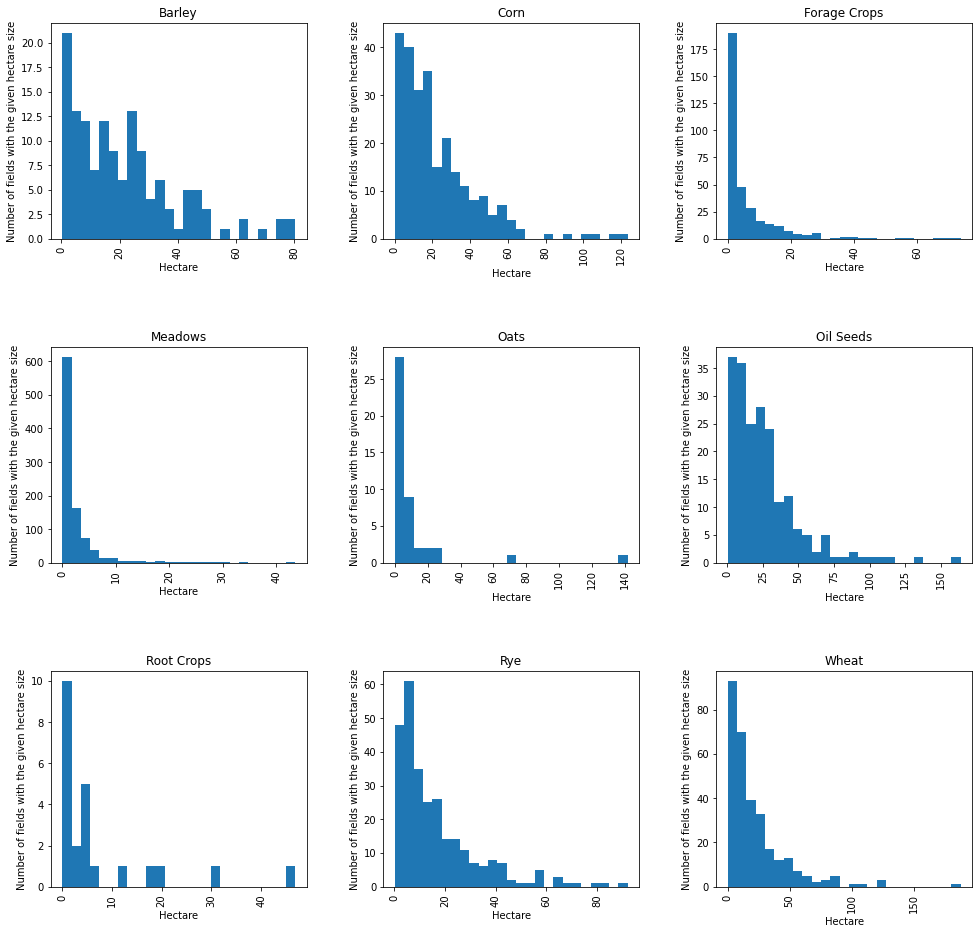

In [13]:
#CHECK HECTARE DISTRIBUTION HISTOGRAM BY LABEL: 

#Convert m2 to hectare:
histogram_data = brandenburg_gt.copy(deep=True)
histogram_data['SHAPE_AREA']=brandenburg_gt['SHAPE_AREA']/10000

ax=histogram_data.hist( by='crop_name',column = 'SHAPE_AREA', bins=25,figsize=(16,16))
for i in range(ax.shape[0]): 
    for j in range(ax.shape[1]): 
        ax[i][j].set_ylabel("Number of fields with the given hectare size")
        ax[i][j].set_xlabel("Hectare")
        

For Brandenburg, the ground-truths of year 2018 are from tile 18E-242N as can be observed below:

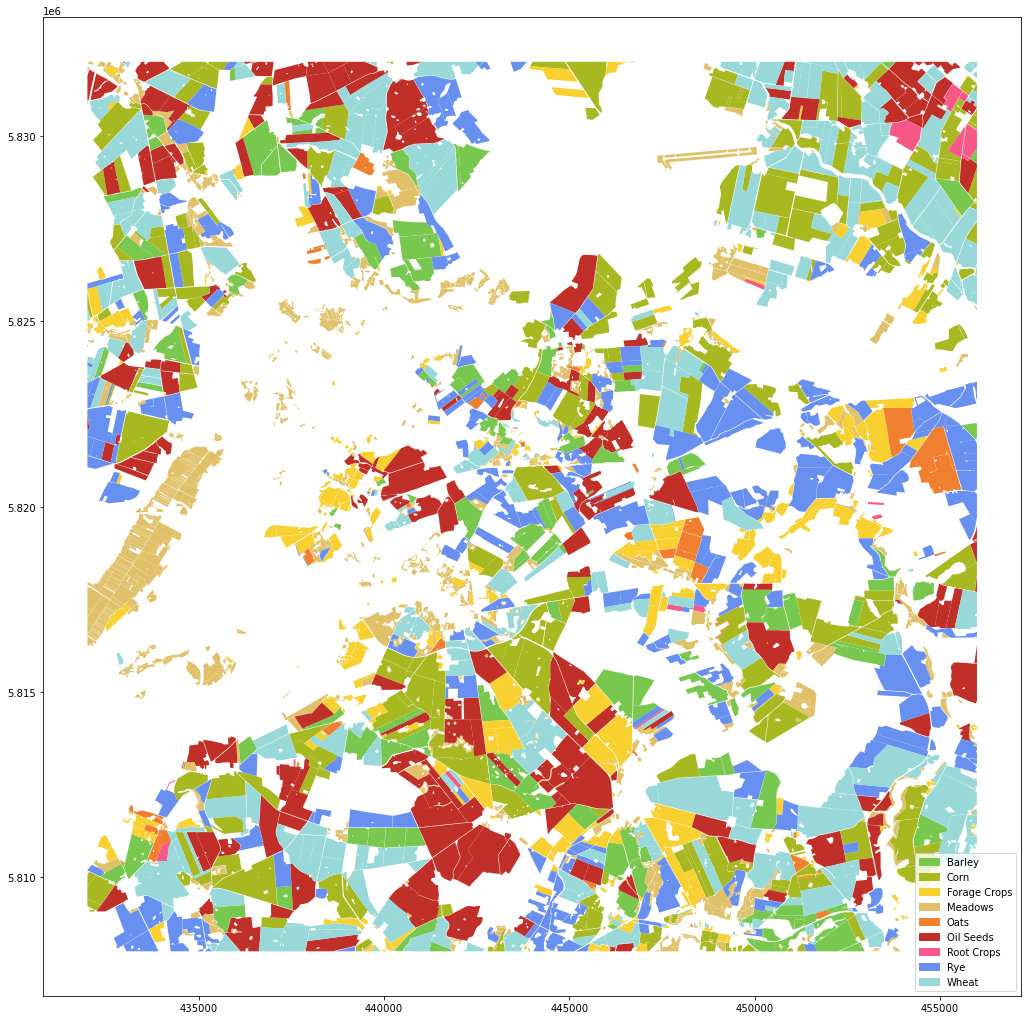

In [14]:
#DISPLAY TARGET FIELDS ON THE MAP BY LABEL: 

fig, ax = plt.subplots(figsize=(18, 18))
counter=0
legend_elements = []
for name, group in brandenburg_gt.groupby('crop_name'):
    group.plot(ax=ax,color=colors_list[counter])
    legend_elements.append(Patch(facecolor=colors_list[counter], edgecolor=colors_list[counter],
                         label=name))
    counter+=1

ax.legend(handles=legend_elements,loc='lower right')


### 1.2 Data Types for Brandenburg <a name="dt1"></a>

The input images are from _Sentinel-1_, _Sentinel-2_ and _Planet Fusion_, with following details: 

 * _Planet Fusion Surface Reflection_ (PF-SR) imagery contains 4 channels in total: `[blue, green, red, NIR]` channels in order, with 3-meter resolution and the provided data is in `TIFF` imaging format.. For more details, you can refer to the specifications of [PLANETSCOPE]( https://www.planet.com/products/planet-imagery/). 

* _Sentinel-1_ (S1) imagery contains 3 channels in total: `[VV, VH, ANGLE]` where _V_ and _H_ stand for vertical and horizontal orientations, respectively, and _ANGLE_ stores the angle of observation to the earth surface as described [here](https://www.nrcan.gc.ca/maps-tools-and-publications/satellite-imagery-and-air-photos/tutorial-fundamentals-remote-sensing/microwave-remote-sensing/radar-image-distortions/9325). The data is collected in Interferometric Wide (IW) swath mode and it includes both ascending and descending orbit directions. For further information about _Sentinel-1_ imagery, please refer to [Sentinel Hub](https://docs.sentinel-hub.com/api/latest/data/sentinel-1-grd/). 


* _Sentinel-2_ includes all L2A bands in the following order `[B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12]`. The bands that have original spatial resolution of `20m` and `60m` are interpolated with a nearest-neighbour method to a `10m` resolution. More information about the interpolation process [here](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#processing-options). Moreover, the cloud probability mask `CLP` is also provided, for more details please refer to [Sentinel Hub](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#available-bands-and-data).

#### 1.2.1 Explore Planet Fusion Data <a name="bepfd"></a>

In [13]:
brandenburg_planet_train_dir='data/planet/UTM-24000/33N/18E-242N/PF-SR/'
brandenburg_gt_dir='data/brandenburg-gt/brandenburg_crops_train_2018.geojson'

In [14]:
#INITIALIZE THE DATA READER TO OBSERVE THE FIELDS FROM PLANET DATA: 

# Choose some days of the year to plot
selected_days_of_year = [10,20,30,40, 50] #from 365 days of the year

#Initialize data reader for planet images
planet_reader = iter(PlanetReader(input_dir=brandenburg_planet_train_dir,
                                  label_dir=brandenburg_gt_dir,
                                  selected_time_points=selected_days_of_year))


INFO: Coordinate system of the data is: EPSG:32633
INFO: Ignoring 30/2534 fields with area < 1000m2


INFO: Extracting time series into the folder: /local_home/kuzu_ri/GIT_REPO/starter-pack-ai4food-v0.0.1/notebook/data/planet/UTM-24000/33N/18E-242N/PF-SR/time_series: 100%|██████████| 2504/2504 [00:00<00:00, 12153.10it/s]


In [15]:
#DEFINE TRUE COLOR IMAGING AND NDVI INDEXING FUNCTIONS FOR VISUALISATION OF PLANET DATA: 

#Define NDVI index for Planet Fusion images
def ndvi(X):
    red = X[2]
    nir = X[3]
    return (nir-red) / (nir + red)

#Define True Color for Planet Fusion images
def true_color(X):
    blue = X[0]/(X[0].max()/255.0)
    green = X[1]/(X[1].max()/255.0)
    red = X[2]/(X[2].max()/255.0)
    tc = np.dstack((red,green,blue)) 
    
    return tc.astype('uint8')


  0%|          | 0/9 [00:00<?, ?it/s]

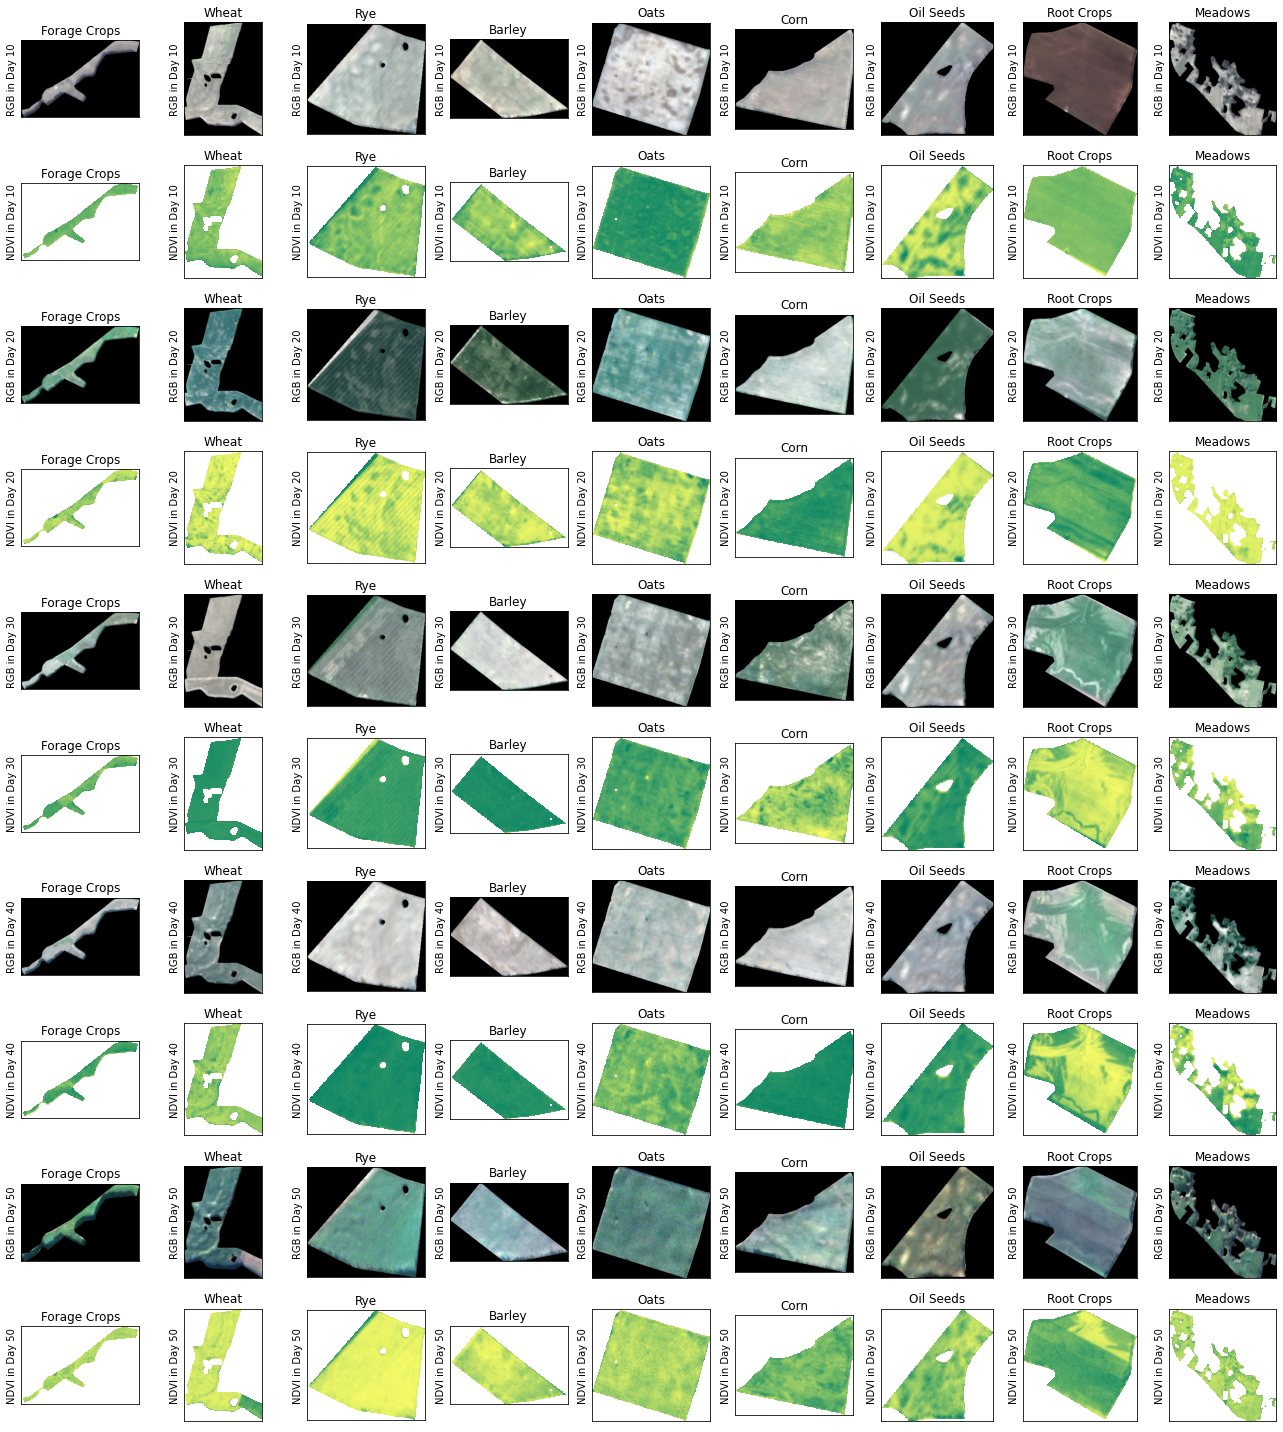

In [16]:
#VISUALISE SOME OF THE FIELDS FROM PLANET DATA: 

#Initialize plot cells
num_row = 2 * len(selected_days_of_year)
num_col = len(label_ids)
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))

#Display one sample field for each crop type
pbar = tqdm(total=len(label_ids))
for crop_id, crop_name in zip(label_ids,label_names):
    while True:
        # read a field sample
        X,y,mask = next(planet_reader) 
        
        width=X.shape[-1]
        height=X.shape[-2]
        
        #Get one sample for each crop type, and
        #consider large areas (at least 200x200) to display
        if y == crop_id and width>200 and height>200:
            for i, day in enumerate(selected_days_of_year):
                
                # Display RGB image of the field in a given week for a given crop type
                ax = axes[(2*i)%num_row, crop_id%num_col]
                ax.title.set_text('{}'.format(crop_name))
                ax.set_ylabel('RGB in Day {}'.format(day))
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(true_color(X[i]))
                
                # Display NDVI index of the field in a given day for a given crop type
                ax = axes[(2*i+1)%num_row, crop_id%num_col]
                ax.title.set_text('{}'.format(crop_name))
                ax.set_ylabel('NDVI in Day {}'.format(day))
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(ndvi(X[i]),cmap=plt.cm.summer)
                
            #if one sample selected for a crop type, break the WHILE loop
            pbar.set_description("Plotting {} Fields".format(crop_name))
            pbar.update(1)
            break
        
        
plt.tight_layout()
plt.show()
pbar.set_description("Plotting Complete!")
pbar.close()


#### 1.2.2 Explore Sentinel-1 Data <a name="bes1d"></a>

In [30]:
brandenburg_gt_dir='data/brandenburg-gt/brandenburg_crops_train_2018.geojson'
brandenburgs_s1_asc_train_dir = "data/sentinel-1/s1-asc-utm-33N-18E-242N-2018.zip"
brandenburgs_s1_dsc_train_dir = "data/sentinel-1/s1-dsc-utm-33N-18E-242N-2018.zip"

In [31]:
#INITIALIZE THE DATA READER TO OBSERVE THE FIELDS FROM PLANET DATA: 

# Choose some days of the year to plot
selected_data_indices = [10,20,30,40,50] #beware that S1 data is not daily, 

#Initialize data reader for planet images
s1_reader = iter(S1Reader(input_dir=brandenburgs_s1_asc_train_dir,
                                  label_dir=brandenburg_gt_dir,
                                  selected_time_points=selected_data_indices))



INFO: Found folder in data/sentinel-1/s1-asc-utm-33N-18E-242N-2018, no need to unzip
INFO: Ignoring 30/2534 fields with area < 1000m2


INFO: Extracting time series into the folder: data/sentinel-1/s1-asc-utm-33N-18E-242N-2018/time_series: 100%|██████████| 2504/2504 [00:00<00:00, 5893.15it/s]


In [32]:
#DEFINE NDVI INDEXING FOR VISUALISATION OF  S1 DATA: 

def ndvi(X):
    VV = X[0]
    VH = X[1]
    dop = (VV/(VV+VH))
    m = 1 - dop
    value = (np.sqrt(dop))*((4*(VH))/(VV+VH))
    
    return value


  0%|          | 0/9 [00:00<?, ?it/s]

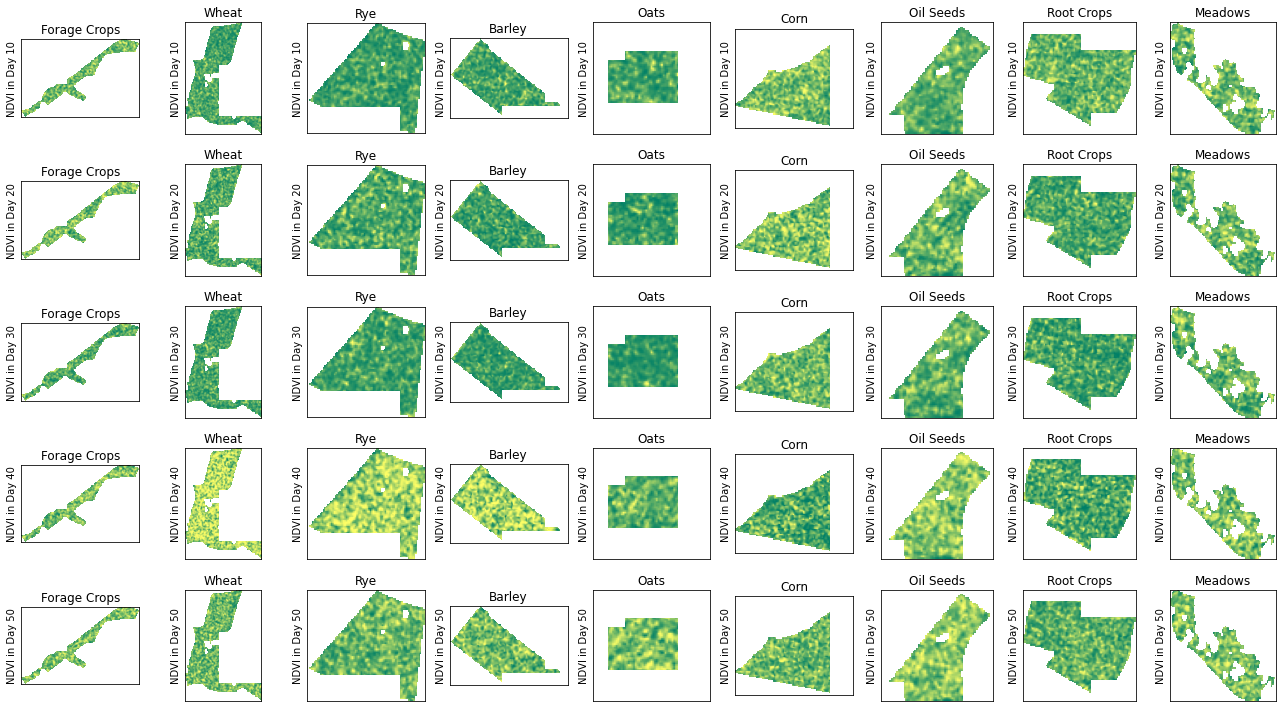

In [33]:
#VISUALISE SOME OF THE FIELDS FROM S1 DATA: 

#Initialize plot cells
num_row = len(selected_data_indices)
num_col = len(label_ids)
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))

#Display one sample field for each crop type
pbar = tqdm(total=len(label_ids))
for crop_id, crop_name in zip(label_ids,label_names):
    while True:
        # read a field sample
        X,y,mask = next(s1_reader) 
        
        width=X.shape[-1]
        height=X.shape[-2]
        
        #Get one sample for each crop type, and
        #consider large areas (at least 60x60) to display
        if y == crop_id and width>60 and height>60:
            for i, day in enumerate(selected_data_indices):
                 
                # Display NDVI index of the field in a given day for a given crop type
                ax = axes[i%num_row, crop_id%num_col]
                ax.title.set_text('{}'.format(crop_name))
                ax.set_ylabel('NDVI in Day {}'.format(day))
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(ndvi(X[i]*mask),cmap=plt.cm.summer)
                
            #if one sample selected for a crop type, break the WHILE loop
            pbar.set_description("Plotting {} Fields".format(crop_name))
            pbar.update(1)
            break
        
        
plt.tight_layout()
plt.show()
pbar.set_description("Plotting Complete!")
pbar.close()


In [17]:
#INITIALIZE DATA LOADERS FOR TRAINING AND EVALUATION: 

#Get data transformer for planet images
planet_transformer=PlanetTransform()

#Initialize data reader for planet images
planet_reader = PlanetReader(input_dir=brandenburg_planet_train_dir,
                             label_dir=brandenburg_gt_dir,
                             label_ids=label_ids,
                             transform=planet_transformer.transform,
                             min_area_to_ignore=1000)

#Initialize data loaders
data_loader=DataLoader(train_val_reader=planet_reader, validation_split=0.25)
train_loader=data_loader.get_train_loader(batch_size=8, num_workers=1)
valid_loader=data_loader.get_validation_loader(batch_size=4, num_workers=1)


INFO: Coordinate system of the data is: EPSG:32633
INFO: Ignoring 30/2534 fields with area < 1000m2


INFO: Extracting time series into the folder: /local_home/kuzu_ri/GIT_REPO/starter-pack-ai4food-v0.0.1/notebook/data/planet/UTM-24000/33N/18E-242N/PF-SR/time_series: 100%|██████████| 2504/2504 [00:00<00:00, 11649.19it/s]

INFO: Training data loader initialized.
INFO: Validation data loader initialized.


In [18]:
#INITIALIZE TRAINING MODEL: 
INPUT_DIM=4  # number of channels in Planet Fusion data
SEQUENCE_LENGTH=122  #Sequence size of Weekly Planet Fusion Data
DEVICE='cpu' 
START_EPOCH=0
TOTAL_EPOCH=10

model = SpatiotemporalModel(input_dim=INPUT_DIM, num_classes=len(label_ids), sequencelength=SEQUENCE_LENGTH, device=DEVICE)
    
# OPTIONAL: trying gradient clipping to avoid loss being NaN.
clip_value = 1e-2
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))


INFO: model initialized with name:mobilenet_v3_small_LSTM


In [19]:
#INITIALIZE MODEL OPTIMIZER AND LOSS CRITERION: 

#Initialize model optimizer and loss criterion:
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
loss_criterion = CrossEntropyLoss(reduction="mean")


In [25]:
#SET LOG DIRECTORY FOR THE TRAINING AND VALIDATION OUTPUTS:

log = list()
logdir = os.path.join('temp_planet/', model.modelname)
os.makedirs(logdir, exist_ok=True)
print("INFO: Logging results will be saved to {}".format(logdir))
summarywriter = SummaryWriter(log_dir=logdir)
snapshot_path = os.path.join(logdir, "model.pth.tar")


INFO: Logging results will be saved to temp_planet/mobilenet_v3_small_LSTM


In [26]:
#IF THERE IS ALREADY A TRAINED MODEL, RESUME IT:

snapshot_path = os.path.join(logdir, "model.pth.tar")
if os.path.exists(snapshot_path):
    checkpoint = torch.load(snapshot_path)
    START_EPOCH = checkpoint["epoch"]
    log = checkpoint["log"]
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    model.load_state_dict(checkpoint["model_state"])
    print(f"INFO: Resuming from {snapshot_path}, epoch {START_EPOCH}")

INFO: Resuming from temp_planet/mobilenet_v3_small_LSTM/model.pth.tar, epoch 4


In [ ]:
#DEFINE TRAINING AND VALIDATION EPOCH FUNCTIONS:


for epoch in range(START_EPOCH, TOTAL_EPOCH):
    train_loss = tveu.train_epoch(model, optimizer, loss_criterion, train_loader, device=DEVICE)
    valid_loss, y_true, y_pred, *_ = tveu.validation_epoch(model, loss_criterion, valid_loader, device=DEVICE)
    
    
    scores = tveu.metrics(y_true.cpu(), y_pred.cpu())
    
    scores_msg = ", ".join([f"{k}={v:.2f}" for (k, v) in scores.items()])
    
    valid_loss = valid_loss.cpu().detach().numpy()[0]
    train_loss = train_loss.cpu().detach().numpy()[0]

    scores["epoch"] = epoch
    scores["train_loss"] = train_loss
    scores["valid_loss"] = valid_loss
    log.append(scores)

    summarywriter.add_scalars("losses", dict(train=train_loss, valid=valid_loss), global_step=epoch)
    summarywriter.add_scalars("metrics",
                              {key: scores[key] for key in
                               ['accuracy', 'kappa', 'f1_micro', 'f1_macro', 'f1_weighted', 
                                'recall_micro','recall_macro', 'recall_weighted', 
                                'precision_micro', 'precision_macro','precision_weighted']},
                                global_step=epoch)

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred.cpu().detach().numpy(), labels=np.arange(len(label_ids)))
    summarywriter.add_figure("confusion_matrix",tveu.confusion_matrix_figure(cm, labels=label_ids),global_step=epoch)

    log_df = pd.DataFrame(log).set_index("epoch")
    log_df.to_csv(os.path.join(logdir, "train_log.csv"))

    torch.save(dict( model_state=model.state_dict(),optimizer_state=optimizer.state_dict(), epoch=epoch, log=log),snapshot_path)
    if len(log) > 2:
        if valid_loss < np.array([l["valid_loss"] for l in log[:-1]]).min():
            best_model = snapshot_path.replace("model.pth.tar","model_best.pth.tar")
            print(f"INFO: New best model with valid_loss {valid_loss:.2f} at {best_model}")
            shutil.copy(snapshot_path, best_model)

    print(f"INFO: epoch {epoch}: train_loss {train_loss:.2f}, valid_loss {valid_loss:.2f} " + scores_msg)

valid loss=2.09: 100%|██████████| 157/157 [00:19<00:00,  7.89it/s]


INFO: epoch 4: train_loss 1.06, valid_loss 2.63 accuracy=0.39, kappa=0.22, f1_micro=0.39, f1_macro=0.18, f1_weighted=0.35, recall_micro=0.39, recall_macro=0.22, recall_weighted=0.39, precision_micro=0.39, precision_macro=0.21, precision_weighted=0.39


valid loss=0.93: 100%|██████████| 157/157 [00:20<00:00,  7.80it/s]


new best model with valid_loss 1.62 at temp_planet/mobilenet_v3_small_LSTM/model_best.pth.tar
INFO: epoch 5: train_loss 1.30, valid_loss 1.62 accuracy=0.42, kappa=0.26, f1_micro=0.42, f1_macro=0.18, f1_weighted=0.38, recall_micro=0.42, recall_macro=0.22, recall_weighted=0.42, precision_micro=0.42, precision_macro=0.21, precision_weighted=0.40


valid loss=2.49:  31%|███       | 48/157 [00:07<00:15,  6.86it/s]


Kondmann, Lukas, et al. (2021), 
[DENETHOR: The DynamicEarthNET dataset for Harmonized, inter-Operable, analysis-Ready, daily crop monitoring](https://openreview.net/pdf?id=uUa4jNMLjrL)


In [ ]:
# TEST ON THE MODEL:

if os.path.exists(best_model):
    checkpoint = torch.load(best_model)
    START_EPOCH = checkpoint["epoch"]
    log = checkpoint["log"]
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    model.load_state_dict(checkpoint["model_state"])
    print(f"INFO: Resuming from {best_model}, epoch {START_EPOCH}")

### 1.2 Sentinel-2 time-series <a name="sentinel-2"></a>

The input images are Sentinel-2 L2A acquired over a 6-months period, from March 1st to September 1st 2019. 

The following data will be downloaded:

 * `BANDS`: all 12 Sentinel-2 L2A bands. The bands are in the following order `[B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12]`. The bands that have original spatial resolution of `20m` and `60m` are interpolated with a nearest-neighbour method to a `10m` resolution. More information about the interpolation process [here](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#processing-options); 
 * `SCL`: Sen2Cor scene classification mask;
 * `IS_DATA`: binary mask denoting data/no-data pixels;
 * `CLP`, `CLM`: `s2cloudless` cloud probability and cloud mask. More details about these layers can be found [here](https://docs.sentinel-hub.com/api/latest/user-guides/cloud-masks/).
 
More details about the bands can be found [here](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#available-bands-and-data).

In [ ]:
# Download parameters - DO NOT CHANGE
S2_TIME_INTERVAL = ('2019-03-01','2019-09-01')

S2_RESOLUTION = 10 #metres
S2_MAXCC = 0.5
S2_TIME_DELTA = 120

MAX_THREADS = 5

Example download for the first bounding box.

In [ ]:
bbox = BBox(bboxes.iloc[0].geometry, crs=CRS(bboxes.crs))

`eo-learn` task to download images from SentinelHub.

In [ ]:
get_s2_l2a = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands_dtype=np.uint16,
    resolution=S2_RESOLUTION,
    maxcc=S2_MAXCC,
    time_difference=timedelta(minutes=S2_TIME_DELTA),
    data_collection=DataCollection.SENTINEL2_L2A,
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'),
                     (FeatureType.MASK, 'SCL'),
                     (FeatureType.MASK, 'CLM'),
                     (FeatureType.DATA, 'CLP')],
    max_threads=MAX_THREADS,
    config=sh_config
)

Download images for given `bbox` and `time_interval`.

In [ ]:
%%time
s2_l2a_eop = get_s2_l2a.execute(bbox=bbox, time_interval=S2_TIME_INTERVAL)

The data is now stored in an [EOPatch](https://eo-learn.readthedocs.io/en/latest/examples/core/CoreOverview.html#EOPatch), where each raster feature is stored as a `numpy` array, vector data stored as a `geopandas` dataframe, while dates as `datetime` objects.

This `EOPatch` contains 38 time frames, of `500x500` spatial dimension. All `EOPatches` will have same spatial dimensions, but different temporal frames.

**NOTE:** Band values are stored as digital numbers `DN`s, therefore they need to be mulitplied by the `NORM_FACTORS` (i.e. `1e-4`) to derive reflectances.

In [ ]:
s2_l2a_eop

In [ ]:
scl_dict =  {0: [0, 0, 0], # no data
             1: [1, 0, 0.016], # saturated / defected
             2: [0.525, 0.525, 0.525], # dark area pixels
             3: [0.467, 0.298, 0.043], # cloud shadows
             4: [0.063, 0.827, 0.176], # vegetation
             5: [1, 1, 0.325], # bare soils
             6: [0, 0, 1], # water
             7: [0.506, 0.506, 0.506], # clouds low probability / unclassified 
             8: [0.753, 0.753, 0.753], # clouds medium probability
             9: [0.949, 0.949, 0.949], # clouds high probaility
             10: [0.733, 0.773, 0.925], # cirrus
             11: [0.325, 1, 0.980] # ice / snow
           }

Visualise data in `EOPatch`.

In [ ]:
# choos one time index [0..37] to visualise
tidx = 28

vis_factor = 3.5

norm_factor = s2_l2a_eop.scalar['NORM_FACTORS'][tidx]

fig, axs = plt.subplots(figsize=(25, 6), ncols=4)

axs[0].imshow(vis_factor*s2_l2a_eop.data['BANDS'][tidx][..., [3, 2, 1]]*norm_factor,
              extent=get_extent(s2_l2a_eop));
axs[0].set_title(f'S2 L2A - {s2_l2a_eop.timestamp[tidx]}');

axs[1].imshow(s2_l2a_eop.mask['IS_DATA'][tidx].squeeze(), 
              vmin=0, vmax=1, extent=get_extent(s2_l2a_eop));
axs[1].set_title('IS_DATA');

axs[2].imshow(s2_l2a_eop.mask['SCL'][tidx].squeeze(), 
              extent=get_extent(s2_l2a_eop), 
              cmap=ListedColormap([np.array(v) for v in scl_dict.values()]),
              vmin=0, vmax=11);
axs[2].set_title('SCL');

axs[3].imshow(s2_l2a_eop.data['CLP'][tidx].squeeze()/255, vmin=0, vmax=1,
              extent=get_extent(s2_l2a_eop));
axs[3].set_title('s2cloudless CLP');

The information in the provided masks can be used to mask out invalid frames containing clouds/snow/fog. Below an example using `IS_DATA` and `CLM` mask to find the percentage of valid data in the 6-months period.

In [ ]:
valid_data = np.mean(s2_l2a_eop.mask['IS_DATA'] & ~s2_l2a_eop.mask['CLM'], 
                     axis=(1,2,3)) 

fig, ax = plt.subplots(figsize=(12.5, 7))
ax.plot(s2_l2a_eop.timestamp, valid_data)
ax.set_ylabel('Fraction of valid data')
ax.grid()

Number of frames for this EOPatch with fraction of valid data greater than 90%. The `SCL` mask and `CLP` masks can be similarly used to estimate data validity fractions.

In [ ]:
np.sum(valid_data>.9)

### 1.3 Reference polygons <a name="reference"></a>

Now that we have the Sentinel-2 time-series data, time to add the information about the target _cultivated land_ map. This mask is derived from a combination of a _land cover_ dataset and a _declared crops_ dataset.

The reference data is stored as polygons in a GeoDB table. The following task retrieves the polygons within each bounding box defined above.

In [ ]:
get_polys = GeoDBVectorImportTask(
    feature=(FeatureType.VECTOR_TIMELESS, 'REFERENCE'), 
    geodb_client=client, 
    geodb_collection='ai4eo_reference',
    geodb_db=GEODB_DATABASE
)

Execute the task and create a new `VECTOR_TIMELESS` feature holding the polys as a `geopandas` dataframe.

In [ ]:
eop = get_polys.execute(eopatch=s2_l2a_eop)

In [ ]:
eop

In [ ]:
eop.vector_timeless['REFERENCE'].head()

Each polygon has a `label` attribute which denotes its land cover. Values between 1 and 30 denote _agricultural land_ including grassland and meadows, values above 1000 denote land cover types like _water_, _forest_ and _build-up_ area, while the label 100 denotes _agricultural land_ of which the crop-type is unknown.

In [ ]:
eop.vector_timeless['REFERENCE'].label.unique()

In [ ]:
df = eop.vector_timeless['REFERENCE']

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

df.query('label<=30').plot(ax=ax, color='xkcd:dull yellow', alpha=.8);
df.query('label<=30').boundary.plot(ax=ax, color='xkcd:dull yellow',  alpha=.8, linewidth=.5, label='agricultural');

df.query('label==100').plot(ax=ax, color='xkcd:black', alpha=.8);
df.query('label==100').boundary.plot(ax=ax, color='xkcd:black',  alpha=.8, linewidth=.5, label='not declared');

df.query('(label>1000) and (label<2000)').plot(ax=ax, color='xkcd:orange', alpha=.8);
df.query('(label>1000) and (label<2000)').boundary.plot(ax=ax, color='xkcd:orange',  alpha=.8, linewidth=.5, label='shrubland');

df.query('label==2000').plot(ax=ax, color='xkcd:jungle green', alpha=.8);
df.query('label==2000').boundary.plot(ax=ax, color='xkcd:jungle green',  alpha=.8, linewidth=.5, label='forest');

df.query('label==3000').plot(ax=ax, color='xkcd:red', alpha=.8);
df.query('label==3000').boundary.plot(ax=ax, color='xkcd:red', alpha=.8, linewidth=.5, label='built-up');

# # no values in this EOPatch
# df.query('(label>4000) and (label<=5000)').plot(ax=ax, color='xkcd:bright teal', alpha=.8);
# df.query('(label>4000) and (label<=5000)').plot(ax=ax, color='xkcd:bright teal', alpha=.8, linewidth=.5, label='wetland');

# # no values in this EOPatch
# df.query('label==6000').plot(ax=ax, color='xkcd:grey', alpha=.8);
# df.query('label==6000').plot(ax=ax, color='xkcd:grey', alpha=.8, linewidth=.5, label='bareland');

df.query('label==7000').plot(ax=ax, color='xkcd:blue', alpha=.8);
df.query('label==7000').plot(ax=ax, color='xkcd:blue', alpha=.8, linewidth=.5, label='water');

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Names of labels and labels mapping to a binary _cultivated/not-cultivated_ mask are provided in the `json` files in the `metadata` folder. 

In the context of this challenge, _cultivated land_ denotes arable land that is typically worked by ploughing, sowing and raising crops.

In [ ]:
with open('metadata/cultivated-mapping.json') as jfile:
    cultivated_mapping = {int(k): v for k, v in json.load(jfile).items()}

Labels that will be mapped to _non-cultivated land_. These labels are a union of _agricultural land_ that is **not** cultivated, e.g. grassland/meadows, tree plantations, greenhouses, and _land covers_ that are not _agricultural land_, e.g. build-up area, water, forest, shrubland.

In [ ]:
print(cultivated_mapping[0])

Labels that will be mapped to _cultivated land_.

In [ ]:
print(cultivated_mapping[1])

Special class which denotes agricultural land that is **not** declared as a specific _cultivated land_. These pixels will have similarities to _cultivated land_, although information is missing about the exact parcel features. For this reason, these polygons will **not** be used to compute the validation metrics.

You are free to use these polys as you wish.

In [ ]:
print(cultivated_mapping[2])

Display names of crops and land cover for each label.

In [ ]:
with open('metadata/label-names.json') as jfile:
    label_names = {int(k): v for k, v in json.load(jfile).items()}

_Not-cultivated land_.

In [ ]:
for ncl in cultivated_mapping[0]:
    prefix = 'Crop-types' if ncl <100 else 'Land cover'
    print(f'{prefix} for label {ncl}:')
    print(label_names[ncl])
    print()

_Cultivated land_

In [ ]:
for cl in cultivated_mapping[1]:
    prefix = 'Crop-types' if cl <100 else 'Land cover'
    print(f'{prefix} for label {cl}:')
    print(label_names[cl])
    print()

**NOTE:** although these labels are mapped to a binary mask for training/testing, you can use label information for sampling of pixels and image chips.

**NOTE:** there is a very small number of polygons where crop declarations disagree with the land cover information, i.e. there is a declared cultivated alnd where the land cover indicates it is not agricultural. We leave the choice to you on how to deal with these polygons, e.g. whether to consider them as _cultivated_ or _not-cultivated_.

Now we can rasterize the reference labels, to allow further processing and model training. **The reference polygons are rasterised at the target spatial resolution of 2.5m**, resulting in a `4x` spatial enhancement. 

Three masks are added to the `EOPatch`:

 * `CULTIVATED`: this mask is the target output used in training and testing of your method;
 * `NOT_DECLARED`: this mask marks pixels that are ignored in the calculation of the validation metrics;
 * `ALL_POLYS`: all polygons are rasterised with given `label`. Use this to customise your sampling given land cover and crop-type information.
 
A negative buffer of 2.5m is applied prior to rasterisation, in order to single out neighbouring touching polygons.

In [ ]:
MAP_RESOLUTION = 2.5 #metres

In [ ]:
valid_polys_to_mask = VectorToRaster((FeatureType.VECTOR_TIMELESS, 'REFERENCE'),
                                     (FeatureType.MASK_TIMELESS, 'CULTIVATED'),
                                     values=cultivated_mapping[1],
                                     values_column='label',
                                     raster_resolution=MAP_RESOLUTION,
                                     raster_dtype=np.uint8,  
                                     all_touched=False,
                                     buffer=-MAP_RESOLUTION) 

invalid_polys_to_mask = VectorToRaster((FeatureType.VECTOR_TIMELESS, 'REFERENCE'),
                                      (FeatureType.MASK_TIMELESS, 'NOT_DECLARED'),
                                      values=cultivated_mapping[2],
                                      values_column='label',
                                      raster_resolution=MAP_RESOLUTION,
                                      raster_dtype=np.uint8,
                                      all_touched=False,
                                      buffer=-MAP_RESOLUTION)

all_polys_to_mask = VectorToRaster((FeatureType.VECTOR_TIMELESS, 'REFERENCE'),
                                   (FeatureType.MASK_TIMELESS, 'ALL_POLYS'),
                                   values=None,
                                   values_column='label',
                                   raster_resolution=MAP_RESOLUTION,
                                   raster_dtype=np.uint16,
                                   all_touched=False,
                                   buffer=-MAP_RESOLUTION) # you can modify this buffer

In [ ]:
eop = valid_polys_to_mask.execute(eop)
eop = invalid_polys_to_mask.execute(eop)
eop = all_polys_to_mask.execute(eop)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(eop.mask_timeless['CULTIVATED'].squeeze(), 
          vmin=0, vmax=30, extent=get_extent(eop), 
          interpolation='nearest', cmap=plt.cm.tab20c);

The above tasks rasterise polygons assigning to pixels their `label` values. We add a task that turns the `CULTIVATED` and `NOT_DECLARED` masks into binary masks. 

In [ ]:
class ToBinary(EOTask):
    """ Turn a discrete feature to a binary mask """
    def __init__(self, feature: Tuple[FeatureType, str]):
        """ 
        :param feature: Feature in eopatch to binarise 
        """
        self.feature = feature
        
    def execute(self, eopatch: EOPatch) -> EOPatch:
        """ Over-write existing feature with binary mask """
        eopatch[self.feature] = eopatch[self.feature]>0
        return eopatch

In [ ]:
valid_to_binary = ToBinary((FeatureType.MASK_TIMELESS, 'CULTIVATED'))
invalid_to_binary = ToBinary((FeatureType.MASK_TIMELESS, 'NOT_DECLARED'))

In [ ]:
eop = valid_to_binary.execute(eop)
eop = invalid_to_binary.execute(eop)

In [ ]:
eop

Display target binary _cultivated land_ map, overlayed with the original polygons.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(eop.mask_timeless['CULTIVATED'], 
          interpolation='nearest', 
          cmap=plt.cm.binary_r, extent=get_extent(eop));
df[df.label.isin(cultivated_mapping[1])].plot(ax=ax, 
                                              color='xkcd:ivory', 
                                              alpha=.4, 
                                              linewidth=.5);

### 1.4 Data download <a name="data-download"></a>

We can now create a workflow that downloads and processes the data as shown above, and parallelize the workflow over the 125 bounding boxes.

In [ ]:
# change this path accordingly to your set-up
EOPATCHES_PATH = '../eopatches'
EOPATCHES_TRAIN_PATH = f'{EOPATCHES_PATH}/train/'
EOPATCHES_TEST_PATH = f'{EOPATCHES_PATH}/test/'

if not os.path.exists(EOPATCHES_TRAIN_PATH):
    os.makedirs(EOPATCHES_TRAIN_PATH, exist_ok=True)

if not os.path.exists(EOPATCHES_TEST_PATH):
    os.makedirs(EOPATCHES_TEST_PATH, exist_ok=True)

Task to save the `EOPatch`es to disk for further processing.

In [ ]:
save = SaveTask(path=EOPATCHES_PATH, compress_level=2)

The previous steps are combined into a linear workflow, performing S2 data download, adding the reference polygons, rasterising the polygons to rasters, creating binary masks and saving the eopatches to disk.

In [ ]:
workflow = LinearWorkflow(get_s2_l2a, 
                          get_polys, 
                          valid_polys_to_mask,
                          invalid_polys_to_mask,
                          all_polys_to_mask,
                          valid_to_binary,
                          invalid_to_binary, 
                          save)

In [ ]:
execution_args = []

for irow, row in tqdm(bboxes.iterrows(), total=len(bboxes)):
    bbox = BBox(row.geometry, crs=CRS(bboxes.crs))
    eopatch_folder = f'{"train" if row.is_train else "test"}/eopatch-{row.eop_index}'
    
    eop_exec_args = {get_s2_l2a: {'bbox': bbox, 'time_interval': S2_TIME_INTERVAL},
                     save: {'eopatch_folder': eopatch_folder}}
    
    execution_args.append(eop_exec_args)


In [ ]:
execution_args[:3]

Parallelise the workflow over the workers. Change `NUM_WORKERS` according to your set-up.

In [ ]:
NUM_WORKERS = 4

executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder='.')

executor.run(workers=NUM_WORKERS)

In [ ]:
%matplotlib

executor.make_report()

print('Report was saved to location: {}'.format(executor.get_report_filename()))

**NOTE:** check the report file to see if any execution failed. You can repeat the `executor` run including only the `execution_args` of the failed `EOPatch`es.

**NOTE:** now that all data has been saved to disk, there is no need to run the code above for download. To read the `EOPatch`es, simply use the `LoadTask` as follows.

In [ ]:
load = LoadTask(path=EOPATCHES_PATH)

In [ ]:
eop_rand = bboxes.sample(n=1).iloc[0]

eop_folder = f'{"train" if eop_rand.is_train else "test"}/eopatch-{eop_rand.eop_index}'

reop = load.execute(eopatch_folder=eop_folder)

In [ ]:
reop

### 1.5 Files check <a name="files-check"></a>

Whether you downloaded the data through the APIs or direct link, best to check that all data has been correctly retrieved.

The following code encodes each downloaded numpy file as MD5 hash and compares them to the target MD5 hashes provided in the `metadata` folder. It should take few minutes to compute.

In [ ]:
md5_hashes = md5_encode_files(EOPATCHES_PATH)

If the following fails, there are some issues with the downloaded files.

In [ ]:
assert md5_hashes.equals(pd.read_csv('metadata/hashed-md5-files.csv', 
                                     usecols=['filename', 'hash']))

## 2. Data Processing <a name="data-processing"></a>

This section offers some tips and pointers on how to possibly transform the data in a ML-ready format.

Possible steps are:

 * filter out invalid frames due to clouds/shadows/snow;
 * sample or generate the same number of S2 time-frames for all EOPatches;
 * sample smaller image chips from S2 time-series with corresponding target binary _cultivated land_ map.
 
If you want to use `eo-learn` for these tasks, check out the documentation about existing tasks like filtering and pixel sampling [here](https://eo-learn.readthedocs.io/en/latest/eotasks.html). You can easily implement your own task (as done above) by following [this example](https://eo-learn.readthedocs.io/en/latest/examples/core/CoreOverview.html#EOTask). [Here](https://github.com/sentinel-hub/eo-learn/tree/master/examples) you can find a collection of examples including land cover and crop-type classification.

Below we provide a custom task to sample patchlets/image chips from the Sentinel-2 time-series and the reference map.

In [ ]:
class SamplePatchlets(EOTask):

    SCALE_FACTOR = 4

    def __init__(self, s2_patchlet_size: int, num_samples: int):
        """ Set-up of task 
        
        :param s2_patchlet_size: Size in pixels of resulting patchlet
        :param num_samples: Number of patchlets to sample
        """
        self.s2_patchlet_size = s2_patchlet_size
        self.num_samples = num_samples

    def _calculate_sampled_bbox(self, 
                                bbox: BBox, 
                                r: int, c: int, s: int,
                                resolution: float) -> BBox:
        """ Calculate bounding box of smaller patchlets """
        return BBox(((bbox.min_x + resolution * c,  bbox.max_y - resolution * (r + s)),
                     (bbox.min_x + resolution * (c + s), bbox.max_y - resolution * r)),
                    bbox.crs)

    def _sample_s2(self, 
                   eop: EOPatch, 
                   row: int, col: int, size: int, 
                   resolution: float = 10):
        """ Randomly sample a patchlet from the EOPatch """
        # create a new eopatch for each sub-sample
        sampled_eop = EOPatch(timestamp=eop.timestamp, 
                              scalar=eop.scalar, 
                              meta_info=eop.meta_info)
        
        # sample S2-related arrays
        features = eop.get_feature_list()
        s2_features = [feature for feature in features 
                       if isinstance(feature, tuple) and 
                       (feature[0].is_spatial() and feature[0].is_time_dependent())]
        
        for feature in s2_features:
            sampled_eop[feature] = eop[feature][:, row:row + size, col:col + size, :]
        
        # calculate BBox for new sub-sample
        sampled_eop.bbox = self._calculate_sampled_bbox(eop.bbox, 
                                                        r=row, c=col, s=size, 
                                                        resolution=resolution)
        sampled_eop.meta_info['size_x'] = size
        sampled_eop.meta_info['size_y'] = size
        
        # sample from target maps, beware of `4x` scale factor
        target_features = eop.get_feature(FeatureType.MASK_TIMELESS).keys()
        
        for feat_name in target_features:
            sampled_eop.mask_timeless[feat_name] = \
            eop.mask_timeless[feat_name][self.SCALE_FACTOR*row:self.SCALE_FACTOR*row + self.SCALE_FACTOR*size, 
                                         self.SCALE_FACTOR*col:self.SCALE_FACTOR*col + self.SCALE_FACTOR*size]
        
        return sampled_eop

    def execute(self, eopatch_s2: EOPatch, buffer: int=0,  seed: int=42) -> List[EOPatch]:
        """ Sample a number of patchlets from the larger EOPatch. 
        
        :param eopatch_s2: EOPatch from which patchlets are sampled
        :param buffer: Do not sample in a given buffer at the edges of the EOPatch
        :param seed: Seed to initialise the pseudo-random number generator
        """
        _, n_rows, n_cols, _ = eopatch_s2.data['BANDS'].shape
        np.random.seed(seed)
        eops_out = []
        
        # random sampling of upper-left corner. Change this for non-overlapping patchlets
        for patchlet_num in range(0, self.num_samples):
            row = np.random.randint(buffer, n_rows - self.s2_patchlet_size - buffer)
            col = np.random.randint(buffer, n_cols - self.s2_patchlet_size - buffer)
            sampled_s2 = self._sample_s2(eopatch_s2, row, col, self.s2_patchlet_size)
            eops_out.append(sampled_s2)
        return eops_out

In [ ]:
sample_task = SamplePatchlets(s2_patchlet_size=32, num_samples=4)

In [ ]:
samples = sample_task.execute(eop)

In [ ]:
len(samples)

Let's check a sample

In [ ]:
samples[0]

In [ ]:
tidx = 28
sample = samples[2]
norm_fact = sample.scalar['NORM_FACTORS'][tidx]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(3.5*sample.data['BANDS'][tidx][..., [3,2,1]]*norm_factor, 
          extent=get_extent(sample));
ax.imshow(sample.mask_timeless['CULTIVATED'].squeeze(), 
          vmin=0, vmax=1, alpha=.2, 
          extent=get_extent(sample));

## 3. Submission Example <a name="submission-example"></a>

A valid submission entails submitting a zipped folder containing a tiff file for each of the 25 test bounding boxes at the target **2.5m** resolution, meaning a `2000x2000` pixels binary raster for each test bounding box.

The `.tif` file should be in the `epsg:32633` coordinate reference system, as the data provided, and should be named as the corresponding `EOPatch`, i.e. `eopatch-81.tif`. Check-out the [`ExportToTiff`](https://eo-learn.readthedocs.io/en/latest/eolearn.io.local_io.html#eolearn.io.local_io.ExportToTiff) task to export a feature to  a tif file. The task uses [rasterio](https://rasterio.readthedocs.io/en/latest/topics/writing.html).

The following code shows how to generate a valid submission using a dummy thresholding method.

### 3.1 Prepare a submission <a name="prepare-a-submission"></a>

The following code shows how to run a simple workflow to export the predicted masks for submission. 

The workflow applies the following:

 * reads `EOPatch` from disk and transforms DNs to reflectances
 * filters time-frames based on `CLM` and `IS_DATA` masks
 * computes NDVI and mean NDVI over the filtered timeframes
 * upscales the mean NDVI to the target spatial resolution of 2.5m
 * applies a thresholding on upscaled mean NDVI
 * exports predicted binary mask
 
The workflow is applied on test EOPatches since they are the only files evaluated.

In your method of course you will make use of the training data to develop a machine learning model, and apply the model to the test patches for the prediciton only.

In [ ]:
SUBMISSION_DIR = '../submission'

if not os.path.exists(SUBMISSION_DIR):
    os.makedirs(SUBMISSION_DIR)

In [ ]:
import cv2

from eolearn.features import NormalizedDifferenceIndexTask, SimpleFilterTask
from eolearn.mask import AddValidDataMaskTask
from eolearn.io import ExportToTiff 

In [ ]:
class ComputeReflectances(EOTask):
    """ Apply normalisation factors to DNs """
    def __init__(self, feature):
        self.feature = feature
        
    def execute(self, eopatch):
        eopatch[self.feature] = eopatch.scalar['NORM_FACTORS'][..., None, None] * eopatch[self.feature].astype(np.float32)
        return eopatch

class SentinelHubValidData:
    """
    Combine 'CLM' mask with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return eopatch.mask['IS_DATA'].astype(bool) & np.logical_not(eopatch.mask['CLM'].astype(bool))

    
class AddValidCountTask(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch[(FeatureType.MASK_TIMELESS, self.name)] = np.count_nonzero(eopatch.mask[self.what], axis=0)
        return eopatch
    
    
class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid if the
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

    
class MeanNDVI(EOTask):
    """
    Compute the mean temporal NDVI
    """
    def __init__(self, ndvi_feature, mean_ndvi_feature):
        self.ndvi_feature = ndvi_feature
        self.mean_ndvi_feature = mean_ndvi_feature
        
    def execute(self, eopatch):
        eopatch[self.mean_ndvi_feature] = np.nanmean(eopatch[self.ndvi_feature], axis=0)
        return eopatch
    

class Enhance(EOTask):
    """
    Upscale S2 to target resolution
    """
    def __init__(self, feature_in, feature_out, scale_factor=4):
        self.feature_in = feature_in
        self.feature_out = feature_out
        self.scale_factor = scale_factor
        
    def execute(self, eopatch):
        array_in = eopatch[self.feature_in]
        if array_in.ndim == 4:
            array_out = np.concatenate([cv2.resize(arr.squeeze(), 
                                                   None,
                                                   fx=self.scale_factor, 
                                                   fy=self.scale_factor, 
                                                   interpolation = cv2.INTER_CUBIC) 
                                        for arr in array_in])
        elif array_in.ndim == 3:
            array_out = cv2.resize(array_in.squeeze(), None, 
                                   fx=self.scale_factor, 
                                   fy=self.scale_factor, 
                                   interpolation = cv2.INTER_CUBIC) 
        eopatch[self.feature_out] = array_out[..., np.newaxis]
        return eopatch
    

class Classify(EOTask):
    """ Threshold mean NDVI mask """
    def __init__(self, feature_in, feature_out, low_cut=-1., high_cut=1.):
        self.feature_in = feature_in
        self.feature_out = feature_out
        self.low_cut = low_cut
        self.high_cut = high_cut
        
    def execute(self, eopatch):
        array_in = eopatch[self.feature_in]
        
        new_eopatch = EOPatch(bbox=eopatch.bbox)
        
        new_eopatch[self.feature_out] = np.logical_and(array_in > self.low_cut, 
                                                       array_in <= self.high_cut).astype(np.uint8)
        return new_eopatch

In [ ]:
band_names = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']

# LOAD EOPATCH
load = LoadTask(path=EOPATCHES_PATH)

# COMPUTE REFLECTANCES FROM DNs
normalise = ComputeReflectances((FeatureType.DATA, 'BANDS'))

# CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
ndvi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), 
                                     (FeatureType.DATA, 'NDVI'),
                                     [band_names.index('B08'), 
                                      band_names.index('B04')])

# VALIDITY MASK
# Validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_validmask = AddValidDataMaskTask(SentinelHubValidData(), 'IS_VALID')

# COUNTING VALID PIXELS
# Count the number of valid observations per pixel using valid data mask
add_valid_count = AddValidCountTask('IS_VALID', 'VALID_COUNT')

# FILTER OUT CLOUDY SCENES
# Keep frames with > 95% valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.95)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# COMPUTE MEAN TEMPORAL NDVI
# Compute mean NDVI values over the time-series
mean_ndvi = MeanNDVI((FeatureType.DATA, 'NDVI'), 
                     (FeatureType.DATA_TIMELESS, 'MEAN_NDVI'))

# UPSCALE MEAN NDVI USING BICUBIC INTERPOLATION
# Apply the 4x upscaling by using bicubic interpolation
enhance = Enhance((FeatureType.DATA_TIMELESS, 'MEAN_NDVI'),
                  (FeatureType.DATA_TIMELESS, 'BIG_MEAN_NDVI'))

# THRESHOLD UPSCALED MEAN NDVI
# Apply thesholds to upscaled mean NDVI
classify = Classify((FeatureType.DATA_TIMELESS, 'BIG_MEAN_NDVI'),
                    (FeatureType.MASK_TIMELESS, 'PREDICTION'),
                    low_cut=.4, high_cut=.6)

# EXPORT PREDICTION AS TIFF
# Export the predicted binary mask as tiff for submission
export = ExportToTiff(feature=(FeatureType.MASK_TIMELESS, 'PREDICTION'),
                      folder=SUBMISSION_DIR, crs='epsg:32633',
                      image_dtype=np.uint8)

In [ ]:
dummy_workflow = LinearWorkflow(load, 
                                normalise,
                                ndvi,
                                add_sh_validmask,
                                add_valid_count,
                                filter_task,
                                mean_ndvi,
                                enhance,
                                classify,
                                export)

In [ ]:
execution_args = []

for eop_test in tqdm(eops_test):
    eop_exec_args = {load: {'eopatch_folder': f'test/eopatch-{eop_test}'},
                     export: {'filename': f'eopatch-{eop_test}.tif'}}
    
    execution_args.append(eop_exec_args)

In [ ]:
NUM_WORKERS = 4

executor = EOExecutor(dummy_workflow, execution_args, save_logs=True, logs_folder='.')

executor.run(workers=NUM_WORKERS)

In [ ]:
%matplotlib

executor.make_report()

print('Report was saved to location: {}'.format(executor.get_report_filename()))

In [ ]:
!ls {SUBMISSION_DIR}

**NOTE:** you can now zip the `submission` folder and submit it for evaluation.